In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.io.wavfile import read as wav_read
from tqdm import tqdm

# 데이터 경로와 라벨 매핑
path = '/content/drive/MyDrive/Aivle_빅프/donateacry_corpus/'
labels = {
    'belly_pain': path + 'belly_pain/',
    'burping': path + 'burping/',
    'discomfort': path + 'discomfort/',
    'hungry': path + 'hungry/',
    'tired': path + 'tired/'
}

# 스펙트로그램 저장 경로
output_path = '/content/spectrogram_images/'
os.makedirs(output_path, exist_ok=True)

# 스펙트로그램 이미지 생성 및 저장
for label, folder_path in labels.items():
    print(f"Processing label: {label}")
    output_label_path = os.path.join(output_path, label)
    os.makedirs(output_label_path, exist_ok=True)

    for filename in tqdm(os.listdir(folder_path), desc=f"Processing {label}", unit="file"):
        if filename.endswith(".wav"):
            audiofile = os.path.join(folder_path, filename)

            # 오디오 파일 읽기
            try:
                fs, audio = wav_read(audiofile)
            except Exception as e:
                print(f"Error reading {audiofile}: {e}")
                continue

            # 스펙트로그램 생성
            f, t, Sxx = spectrogram(audio, fs=fs, nperseg=256, noverlap=128, window='hann')

            # 로그 스케일 변환
            Sxx_log = 10 * np.log10(Sxx + 1e-10)  # log scale to prevent log(0)

            # 스펙트로그램 저장
            save_path = os.path.join(output_label_path, filename.replace('.wav', '.png'))
            plt.imsave(save_path, Sxx_log, cmap='viridis')

print("Spectrogram generation completed.")

Processing label: belly_pain


Processing belly_pain: 100%|██████████| 16/16 [00:06<00:00,  2.33file/s]


Processing label: burping


Processing burping: 100%|██████████| 8/8 [00:02<00:00,  2.70file/s]


Processing label: discomfort


Processing discomfort: 100%|██████████| 27/27 [00:09<00:00,  2.80file/s]


Processing label: hungry


Processing hungry: 100%|██████████| 382/382 [00:22<00:00, 16.82file/s]


Processing label: tired


Processing tired: 100%|██████████| 25/25 [00:08<00:00,  2.91file/s]

Spectrogram generation completed.


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm

# 데이터 경로와 라벨 매핑
path = '/content/spectrogram_images/'
labels = {
    'belly_pain': path + 'belly_pain/',
    'burping': path + 'burping/',
    'discomfort': path + 'discomfort/',
    'hungry': path + 'hungry/',
    'tired': path + 'tired/'
}

# 스펙트로그램 저장 경로
output_path = '/content/noise_reduction/'
os.makedirs(output_path, exist_ok=True)

# 스펙트로그램 이미지 생성 및 저장
for label, folder_path in labels.items():
    print(f"Processing label: {label}")
    output_label_path = os.path.join(output_path, label)
    os.makedirs(output_label_path, exist_ok=True)

    for filename in tqdm(os.listdir(folder_path), desc=f"Processing {label}", unit="file"):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)

            # 스펙트로그램 이미지 읽기
            image = cv2.imread(image_path)
            if image is None:
                print(f"Unable to read the image from {image_path}")
                continue

            # 이미지를 그레이스케일로 변환
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # 바이너리 임계값 적용
            ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # 거리 변환 계산
            dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

            # 확실한 전경 추출
            ret, sure_fg = cv2.threshold(dist_transform, 0.9 * dist_transform.max(), 255, 0)
            sure_fg = np.uint8(sure_fg)

            # 확실한 배경 추출
            sure_bg = cv2.dilate(binary, None, iterations=6)

            # 전경과 배경의 차이로 미지정 영역 추출
            unknown = cv2.subtract(sure_bg, sure_fg)

            # 마커 생성
            ret, markers = cv2.connectedComponents(sure_fg)

            # 마커 값 조정
            markers = markers + 1
            markers[unknown == 255] = 0

            # Watershed 알고리즘 적용
            markers = cv2.watershed(image, markers)
            image[markers == -1] = [255, 0, 0]  # 경계를 빨간색으로 표시

            # 배경을 검정색으로 마스킹
            image[markers == 1] = [0, 0, 0]

            # 결과 저장 경로 설정
            output_file_path = os.path.join(output_label_path, filename)
            cv2.imwrite(output_file_path, image)


Processing label: belly_pain


Processing belly_pain: 100%|██████████| 16/16 [00:00<00:00, 54.00file/s]


Processing label: burping


Processing burping: 100%|██████████| 8/8 [00:00<00:00, 100.24file/s]


Processing label: discomfort


Processing discomfort: 100%|██████████| 27/27 [00:00<00:00, 99.48file/s]


Processing label: hungry


Processing hungry: 100%|██████████| 382/382 [00:04<00:00, 85.78file/s]


Processing label: tired


Processing tired: 100%|██████████| 24/24 [00:00<00:00, 63.47file/s]


In [3]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

# 데이터 경로와 라벨 매핑
path = '/content/noise_reduction/'
labels = {
    'belly_pain': path + 'belly_pain/',
    'burping': path + 'burping/',
    'discomfort': path + 'discomfort/',
    'hungry': path + 'hungry/',
    'tired': path + 'tired/'
}

# 병합: 'burping' -> 'discomfort'
burping_files = [os.path.join(labels['burping'], f) for f in os.listdir(labels['burping']) if f.endswith(('png', 'jpg', 'jpeg'))]
for file in burping_files:
    shutil.move(file, labels['discomfort'])

In [6]:
import os
from collections import defaultdict

# 데이터 경로와 라벨 매핑
path = '/content/noise_reduction/'
labels = {
    'belly_pain': path + 'belly_pain/',
    'burping': path + 'burping/',
    'discomfort': path + 'discomfort/',
    'hungry': path + 'hungry/',
    'tired': path + 'tired/'
}

# 폴더별 파일 개수 확인
def count_files_in_folders(label_paths):
    file_counts = {}
    for label, folder_path in label_paths.items():
        try:
            file_counts[label] = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        except FileNotFoundError:
            print(f"Folder not found: {folder_path}")
            file_counts[label] = 0
    return file_counts

# 파일 개수 출력
file_counts = count_files_in_folders(labels)
for label, count in file_counts.items():
    print(f"{label}: {count} files")

belly_pain: 16 files
burping: 0 files
discomfort: 35 files
hungry: 382 files
tired: 24 files


In [19]:
# 무작위로 hungry에서 50개 선택
hungry_files = [os.path.join(labels['hungry'], f) for f in os.listdir(labels['hungry']) if f.endswith(('png', 'jpg', 'jpeg'))]
hungry_sampled = random.sample(hungry_files, min(30, len(hungry_files)))

# 데이터 세트 경로 설정
base_split_path = '/content/split_data/'
os.makedirs(base_split_path, exist_ok=True)

for split in ['train', 'valid', 'test']:
    for label in ['belly_pain', 'discomfort', 'hungry', 'tired']:
        os.makedirs(os.path.join(base_split_path, split, label), exist_ok=True)

# 데이터 분할 및 파일 이동
final_labels = ['belly_pain', 'discomfort', 'hungry', 'tired']
for label in final_labels:
    folder_path = labels[label]
    if label == 'hungry':
        all_files = hungry_sampled  # 선택된 50개만 사용
    else:
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    train_files, test_valid_files = train_test_split(all_files, test_size=0.4, random_state=42)
    valid_files, test_files = train_test_split(test_valid_files, test_size=0.5, random_state=42)

    for file in train_files:
        shutil.copy(file, os.path.join(base_split_path, 'train', label))
    for file in valid_files:
        shutil.copy(file, os.path.join(base_split_path, 'valid', label))
    for file in test_files:
        shutil.copy(file, os.path.join(base_split_path, 'test', label))

print("Data preparation completed.")

Data preparation completed.


In [20]:
# 데이터 세트 파일 개수 확인
split_counts = {split: {label: len(os.listdir(os.path.join(base_split_path, split, label))) for label in final_labels} for split in ['train', 'valid', 'test']}

print("Data preparation completed.")
for split, counts in split_counts.items():
    print(f"\n{split.capitalize()} set file counts:")
    for label, count in counts.items():
        print(f"  {label}: {count} files")

Data preparation completed.

Train set file counts:
  belly_pain: 9 files
  discomfort: 21 files
  hungry: 46 files
  tired: 14 files

Valid set file counts:
  belly_pain: 3 files
  discomfort: 7 files
  hungry: 16 files
  tired: 5 files

Test set file counts:
  belly_pain: 4 files
  discomfort: 7 files
  hungry: 15 files
  tired: 5 files


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Resizing, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()

# Input Layer with resizing and normalization
model.add(InputLayer(input_shape=(224, 224, 3)))
model.add(Resizing(64, 64))
model.add(Rescaling(1.0 / 255))

# Convolutional Layers
model.add(Conv2D(64, 3, strides=1, activation='relu', padding='same'))
model.add(Conv2D(128, 3, strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Assuming 5 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,853,508 (64.29 MB)

 Trainable params: 16,853,508 (64.29 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# ReduceLROnPlateau Callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=0.0001,  # Adjusted minimum learning rate
    verbose=1
)

# Data Preparation
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/split_data/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/split_data/valid',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# Model Training
hist = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[reduce_lr]
)

Found 90 images belonging to 4 classes.
Found 31 images belonging to 4 classes.
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2576 - loss: 3.8168 - val_accuracy: 0.2258 - val_loss: 1.3740 - learning_rate: 0.0100
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2232 - loss: 1.3792 - val_accuracy: 0.5161 - val_loss: 1.3628 - learning_rate: 0.0100
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3919 - loss: 1.3587 - val_accuracy: 0.5161 - val_loss: 1.3397 - learning_rate: 0.0100
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5280 - loss: 1.3433
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5238 - loss: 1.3408 - val_accuracy: 0.5161 - val_loss: 1.3146 - learning_rate: 0.0100
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4938 - loss: 1.3220 - val_accuracy: 0.5161 - val_loss: 1.3012 - learning_rate: 0.0050
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

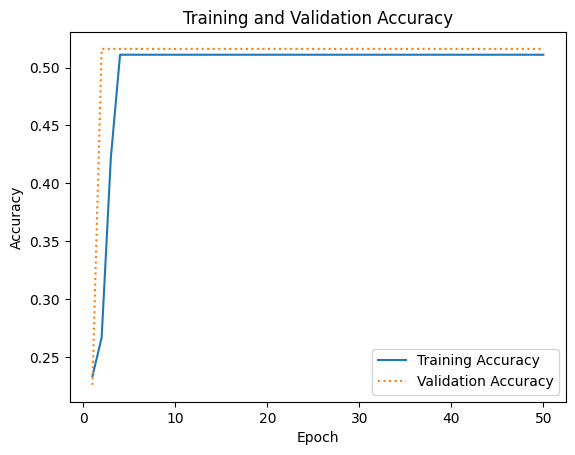

In [23]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [24]:
import glob
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# PNG 파일을 가져오는 함수
def get_png_files(directory):
    folders = ['belly_pain', 'discomfort', 'hungry', 'tired']
    png_files = []

    for folder_name in folders:
        folder_path = os.path.join(directory, folder_name)  # 각 클래스 폴더 경로
        if os.path.exists(folder_path):
            png_files.extend(glob.glob(os.path.join(folder_path, '*.png')))  # 폴더 내 모든 PNG 파일
        else:
            print(f"Folder '{folder_name}' does not exist in '{directory}'.")  # 없는 폴더 경고 메시지

    return png_files

# Directory Path 설정
directory_path = '/content/split_data/test'  # 실제 경로를 명시하세요
png_files_list = get_png_files(directory_path)

# 결과를 저장할 리스트
results = []
class_labels = ['belly_pain', 'discomfort', 'hungry', 'tired']  # 클래스 레이블

for file_path in png_files_list:
    # 이미지 로드 및 전처리
    x = image.load_img(file_path, target_size=(224, 224))  # 모델 입력 크기에 맞게 조정
    x = image.img_to_array(x)  # 배열로 변환
    x = np.expand_dims(x, axis=0)  # 배치 차원 추가

    # 모델 예측
    y = model.predict(x)

    # 결과 저장
    original_label = os.path.basename(os.path.dirname(file_path))  # 폴더 이름으로 원본 레이블 추출
    predicted_label = class_labels[np.argmax(y)]  # 가장 높은 확률의 인덱스에서 예측 레이블 결정
    results.append(f"Original: {original_label}, Predicted: {predicted_label}")

# 결과 출력
print('\nResults:\n')
for result in results:
    print(result)
    print('\n')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━